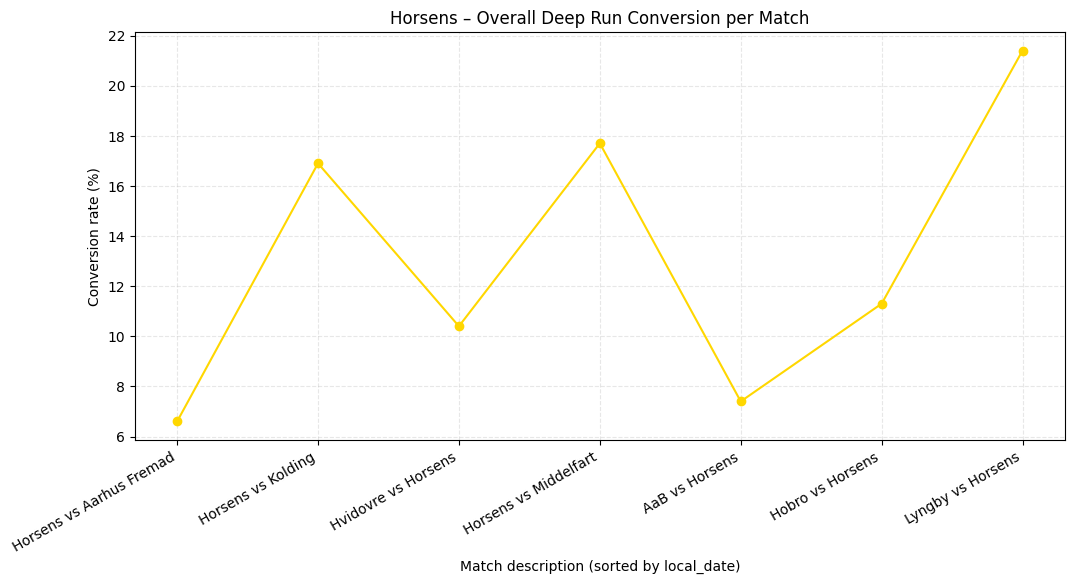


=== Overall (High base OR Pocket OR Width) ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
      Esbjerg                   56.4               12.3                 22.4
     Hvidovre                   55.6               10.2                 18.5
         B_93                   88.3               14.9                 16.7
       Lyngby                   76.3               11.3                 14.7
      Kolding                   73.4               10.6                 13.9
   Middelfart                   55.2                8.0                 13.6
      HB_Køge                   51.0                6.5                 13.1
      Horsens                   79.7               10.0                 13.1
        Hobro                   68.9                9.0                 12.8
Aarhus_Fremad                   74.4                8.9                 11.8
          AaB                   73.8                9.1                 11.7
     Hillerød               

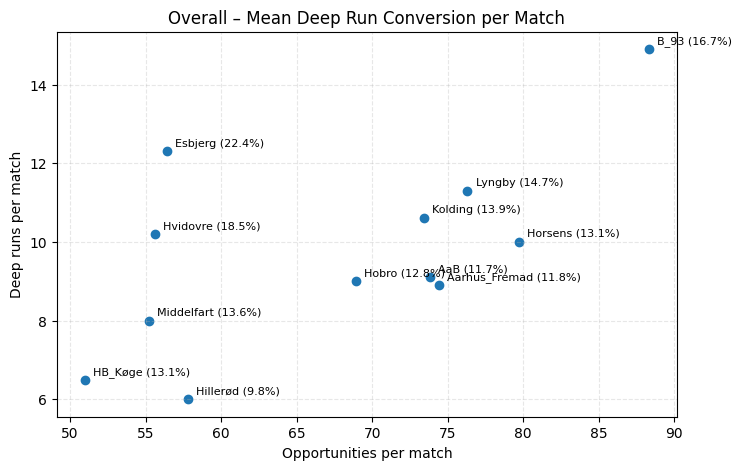


=== High base ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
      Esbjerg                   25.1                3.4                 14.7
     Hvidovre                   27.8                3.5                 12.3
Aarhus_Fremad                   41.1                4.6                 10.8
          AaB                   47.2                4.8                 10.1
      HB_Køge                   27.0                2.5                 10.0
      Horsens                   47.9                4.4                  9.9
       Lyngby                   40.8                3.3                  8.5
         B_93                   51.9                4.7                  8.2
      Kolding                   40.0                3.6                  8.1
        Hobro                   35.5                2.5                  6.8
   Middelfart                   29.6                1.6                  5.6
     Hillerød                   32.4                1.4  

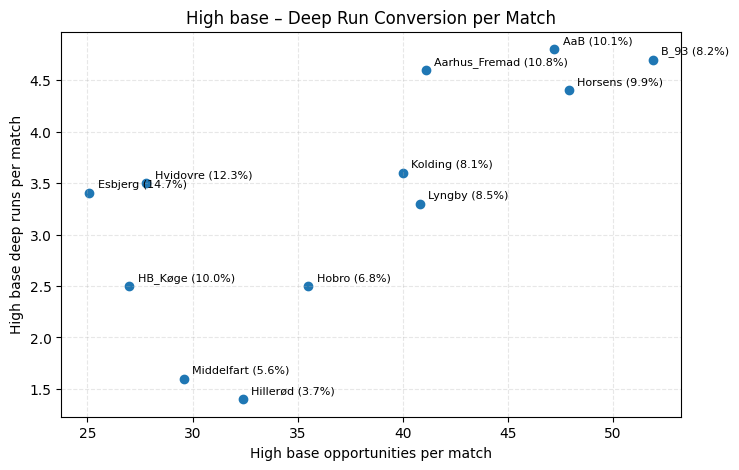


=== Pocket ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
         B_93                   19.4                7.9                 41.0
      Esbjerg                   15.0                5.0                 34.5
     Hvidovre                   14.5                4.8                 33.3
       Lyngby                   16.8                5.0                 30.2
        Hobro                   16.6                4.4                 25.6
      Kolding                   15.3                4.3                 25.2
          AaB                   12.5                3.4                 24.6
Aarhus_Fremad                   14.9                3.3                 22.7
      HB_Køge                   12.5                2.7                 20.7
   Middelfart                   14.2                3.0                 17.6
      Horsens                   16.3                3.1                 17.1
     Hillerød                   13.8                2.2     

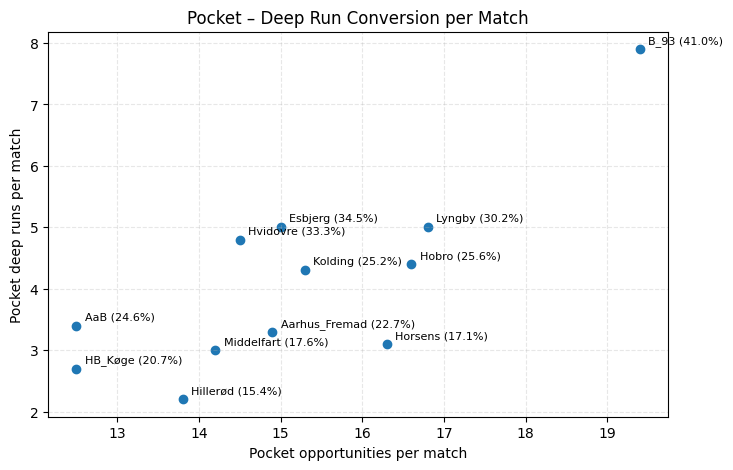


=== Width ===
         Team  Opportunities / match  Deep runs / match  Conversion rate (%)
      Esbjerg                   24.1                6.1                 26.3
   Middelfart                   17.4                4.4                 22.8
     Hvidovre                   19.6                3.8                 19.8
         B_93                   26.6                5.1                 19.4
        Hobro                   23.4                4.5                 19.0
      Horsens                   24.6                4.0                 18.0
      Kolding                   26.6                4.4                 16.6
     Hillerød                   17.5                3.2                 16.5
       Lyngby                   27.5                4.7                 16.2
      HB_Køge                   18.0                2.5                 13.7
Aarhus_Fremad                   28.4                3.4                 11.8
          AaB                   22.0                2.6      

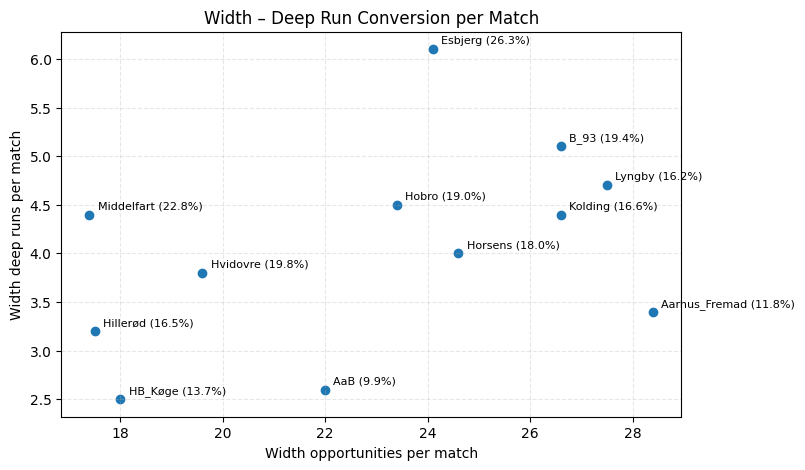

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# -------- CONFIG --------
BASE_PATH = r"C:\Users\Seamus-admin\Documents\GitHub\AC-Horsens-First-Team\DNK_1_Division_2025_2026"
USE_STREAMLIT = False  # set True if running inside Streamlit

if USE_STREAMLIT:
    import streamlit as st

# -------- LOADING --------
def load_all_teams(base_path: str, n_last_matches: int = 200) -> pd.DataFrame:
    teams = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    dfs = []
    for team in teams:
        file_path = os.path.join(base_path, team, f"{team}_on_ball_sequences.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df["team"] = team
            dfs.append(df)

    if not dfs:
        raise FileNotFoundError("No team CSVs found under the base path.")

    df_all = pd.concat(dfs, ignore_index=True)

    # ensure datetime
    df_all["local_date"] = pd.to_datetime(df_all["local_date"], errors="coerce")

    # compute the last N unique dates per team
    lastN_per_team = (
        df_all[["team", "local_date"]]
        .drop_duplicates()
        .sort_values(["team", "local_date"], ascending=[True, False])
    )
    lastN_per_team["date_rank"] = lastN_per_team.groupby("team")["local_date"] \
                                               .rank(method="dense", ascending=False)

    keep_dates = lastN_per_team[lastN_per_team["date_rank"] <= n_last_matches][["team", "local_date"]]

    # filter original to those dates per team
    df_filtered = df_all.merge(keep_dates, on=["team", "local_date"], how="inner")
    return df_filtered

# usage
df_all = load_all_teams(BASE_PATH, n_last_matches=200)
# -------- CORE CALC HELPERS --------
def _mask_for_concept(df: pd.DataFrame, concept: str | None):
    """Return mask for: (concept True) AND (deep_run_opportunity True).
       If concept is None, use OR across High base, Pocket, Width.
    """
    if concept is None:
        concept_mask = (df["High base"] == True) | (df["Pocket"] == True) | (df["Width"] == True)
    else:
        concept_mask = (df[concept] == True)
    opportunity_mask = (df["deep_run_opportunity"] == True)
    return concept_mask & opportunity_mask

def per_match_summary(df: pd.DataFrame, concept: str | None = None) -> pd.DataFrame:
    """
    Build per-match summary for a given concept (or overall if concept=None):
      - opportunities: unique (sequence_id, match_id, team)
      - deep_runs: all rows with deep_run==True
      - conversion per match
    Returns one row per (team, match_id).
    """
    mask = _mask_for_concept(df, concept)

    # Unique opportunities (dedupe by sequence & match & team)
    opps_per_match = (
        df[mask]
        .drop_duplicates(subset=["sequence_id", "match_id", "team"])
        .groupby(["team", "match_id"])
        .size()
        .reset_index(name="opportunities")
    )

    # All deep runs (no dedupe)
    runs_per_match = (
        df[mask & (df["deep_run"] == True)]
        .groupby(["team", "match_id"])
        .size()
        .reset_index(name="deep_runs")
    )

    # Merge & fill
    summary = (
        opps_per_match.merge(runs_per_match, on=["team", "match_id"], how="left")
        .fillna(0)
    )

    # Conversion per match
    summary["conversion_rate_%"] = (
        (summary["deep_runs"] / summary["opportunities"]) * 100
    ).round(1)

    return summary

def mean_per_match_per_team(summary_per_match: pd.DataFrame) -> pd.DataFrame:
    """Average per match for each team (opportunities, deep_runs, conversion%)."""
    mean_df = (
        summary_per_match.groupby("team", as_index=False)[["opportunities", "deep_runs", "conversion_rate_%"]]
        .mean()
        .round(1)
    )
    return mean_df

# -------- PRESENTATION TABLES --------
def format_presentation_table(df_mean: pd.DataFrame, title: str | None = None) -> pd.DataFrame:
    out = df_mean.copy()
    out.columns = ["Team", "Opportunities / match", "Deep runs / match", "Conversion rate (%)"]
    out = out.sort_values("Conversion rate (%)", ascending=False)
    if USE_STREAMLIT:
        if title:
            st.subheader(title)
        st.table(out)
    else:
        if title:
            print(f"\n=== {title} ===")
        print(out.to_string(index=False))
    return out

# -------- PLOTS --------
def scatter_mean_table(mean_df: pd.DataFrame, title: str, xlabel: str, ylabel: str):
    # ensure numeric
    mean_df["opportunities"] = pd.to_numeric(mean_df["opportunities"], errors="coerce").fillna(0)
    mean_df["deep_runs"]     = pd.to_numeric(mean_df["deep_runs"], errors="coerce").fillna(0)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(mean_df["opportunities"], mean_df["deep_runs"])
    for _, row in mean_df.iterrows():
        label = f"{row['team']} ({row['conversion_rate_%']}%)"
        ax.annotate(label, (row["opportunities"], row["deep_runs"]),
                    textcoords="offset points", xytext=(6, 4), fontsize=8)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.3)

    if USE_STREAMLIT:
        st.pyplot(fig, use_container_width=True)
    else:
        plt.show()

def plot_conversion_trend_horsens(df: pd.DataFrame, rolling: int = 1):
    """
    Line chart of Horsens conversion rate per match (Overall = concept=None),
    with x-axis = description, sorted by local_date.
    """
    # Build per-match summary (overall concept)
    overall_match = per_match_summary(df, concept=None)

    # Attach description and local_date
    meta_map = df[df["team"] == "Horsens"][["team", "match_id", "description", "local_date"]].drop_duplicates()
    overall_match = overall_match.merge(meta_map, on=["team", "match_id"], how="left")

    # Horsens only, sorted by local_date
    data = overall_match[overall_match["team"] == "Horsens"].sort_values("local_date")

    # Rolling average if requested
    y = data["conversion_rate_%"]
    if rolling and rolling > 1:
        y = y.rolling(rolling, min_periods=1).mean()

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data["description"], y, marker="o", color="gold")
    ax.set_title("Horsens – Overall Deep Run Conversion per Match")
    ax.set_xlabel("Match description (sorted by local_date)")
    ax.set_ylabel("Conversion rate (%)")
    ax.grid(True, linestyle="--", alpha=0.3)
    fig.autofmt_xdate()

    plt.show()# ---- Example usage ----
plot_conversion_trend_horsens(df_all, rolling=1)

# -------- RUN: OVERALL (High base OR Pocket OR Width) --------
overall_per_match = per_match_summary(df_all, concept=None)
overall_mean = mean_per_match_per_team(overall_per_match)

overall_table = format_presentation_table(
    overall_mean.rename(columns={"team": "Team", "opportunities": "Opportunities / match",
                                 "deep_runs": "Deep runs / match", "conversion_rate_%": "Conversion rate (%)"}),
    title="Overall (High base OR Pocket OR Width)"
)

scatter_mean_table(
    overall_mean.rename(columns={"team": "team"}),
    title="Overall – Mean Deep Run Conversion per Match",
    xlabel="Opportunities per match",
    ylabel="Deep runs per match"
)

# -------- RUN: PER CONCEPT --------
for concept in ["High base", "Pocket", "Width"]:
    per_match = per_match_summary(df_all, concept=concept)
    mean_df = mean_per_match_per_team(per_match)

    format_presentation_table(
        mean_df.rename(columns={"team": "Team", "opportunities": "Opportunities / match",
                                "deep_runs": "Deep runs / match", "conversion_rate_%": "Conversion rate (%)"}),
        title=f"{concept}"
    )

    scatter_mean_table(
        mean_df.rename(columns={"team": "team"}),
        title=f"{concept} – Deep Run Conversion per Match",
        xlabel=f"{concept} opportunities per match",
        ylabel=f"{concept} deep runs per match"
    )

